
# Compute real-time evoked responses using moving averages

This example demonstrates how to connect to an MNE Real-time server
using the RtClient and use it together with RtEpochs to compute
evoked responses using moving averages.

Note: The MNE Real-time server (mne_rt_server), which is part of mne-cpp, has to be running on the same computer.

(65, 321)
Not setting metadata
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Just got epoch 1
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

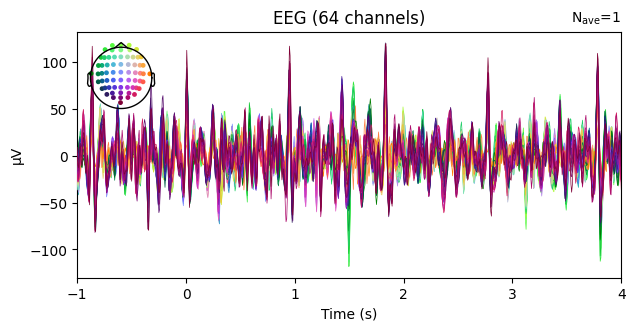

Just got epoch 2
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

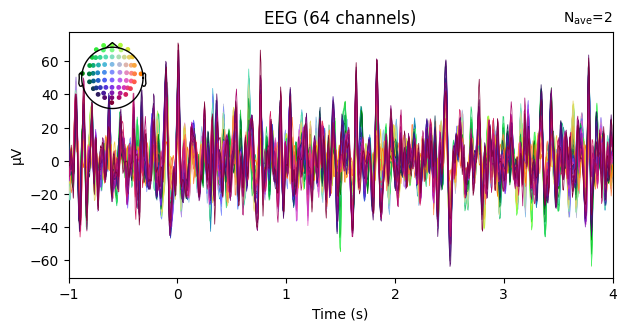

Just got epoch 3
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

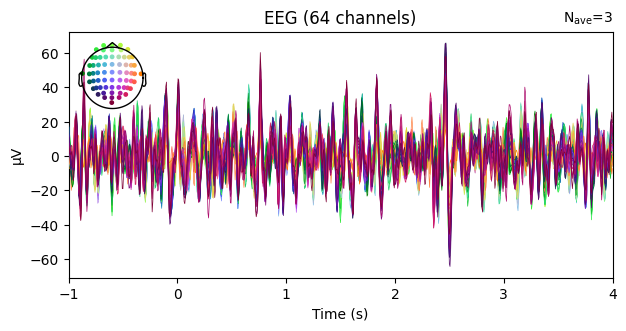

Just got epoch 4
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

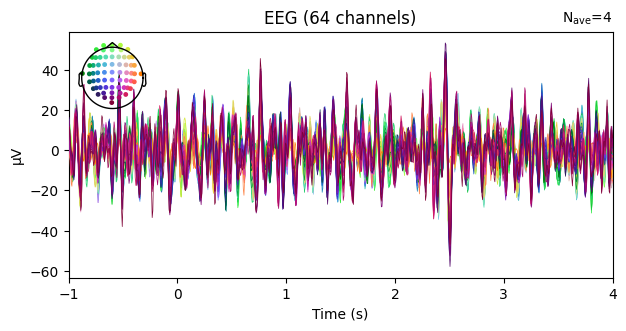

Just got epoch 5
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

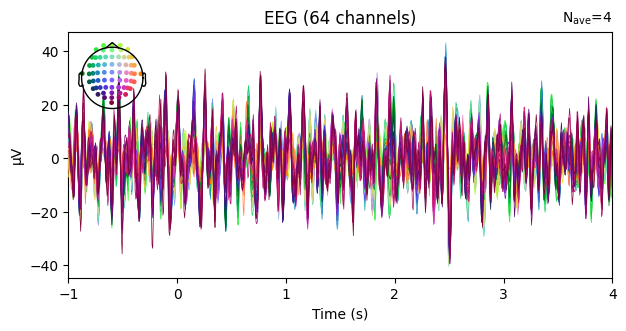

Just got epoch 6
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

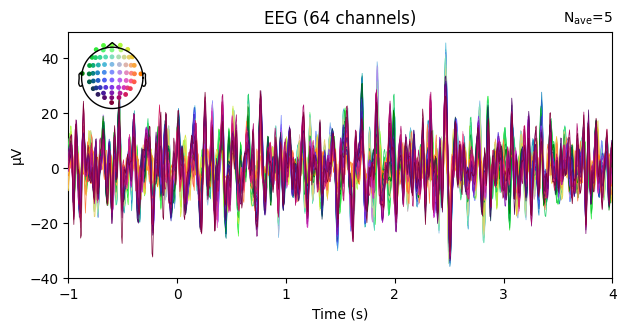

Just got epoch 7
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

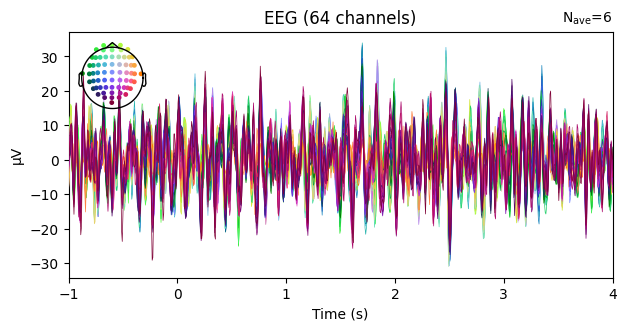

Just got epoch 8
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

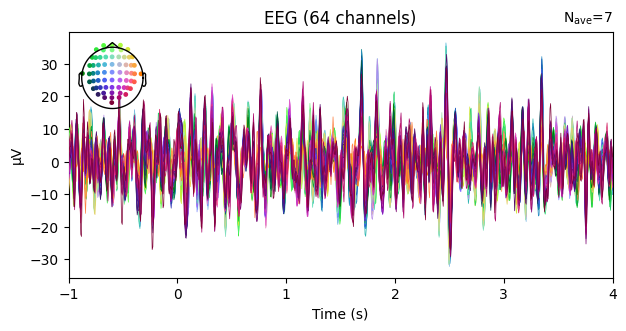

Just got epoch 9
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

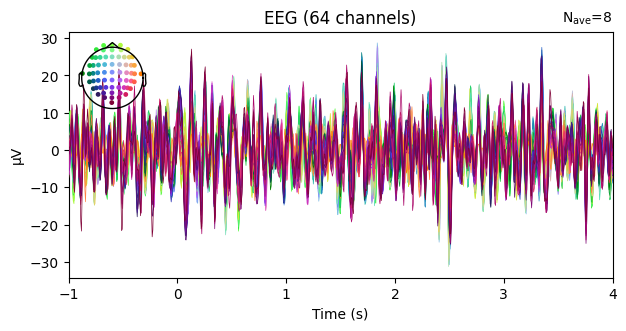

Just got epoch 10
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

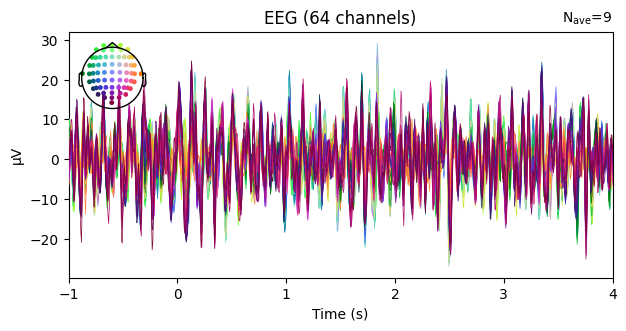

Just got epoch 11
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

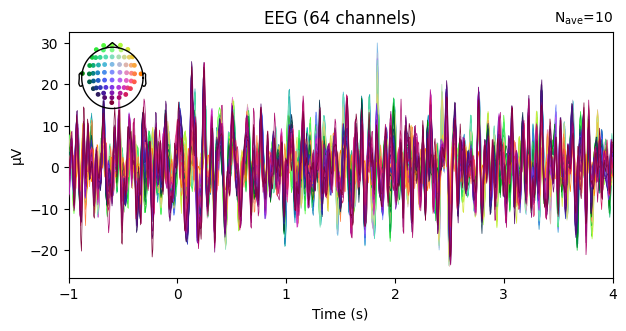

Just got epoch 12
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

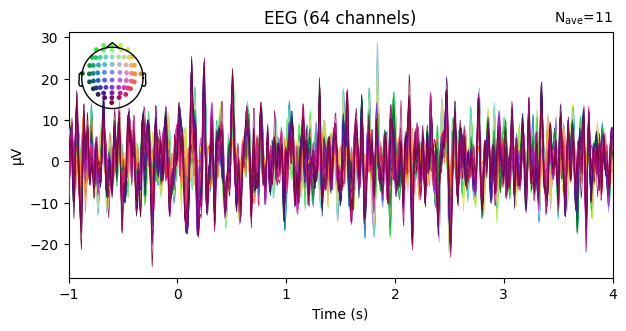

Just got epoch 13
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

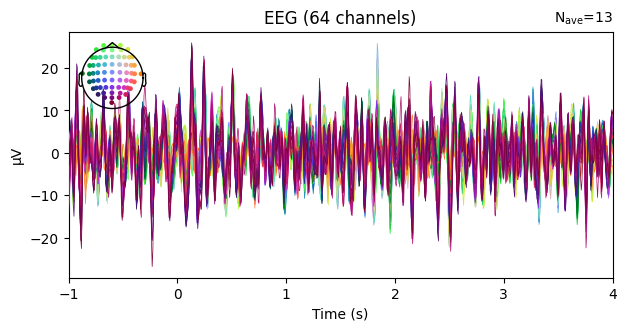

Just got epoch 14
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

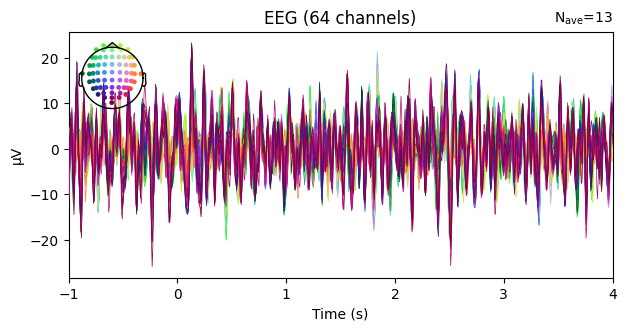

Just got epoch 15
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

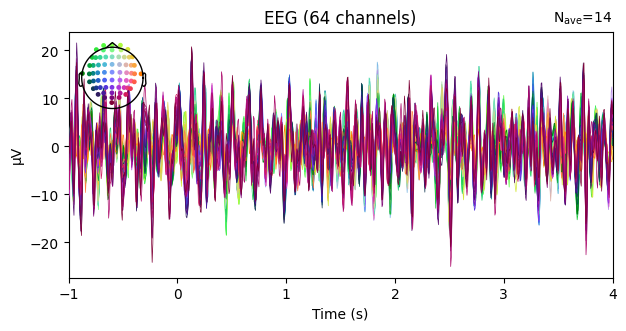

Just got epoch 16
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

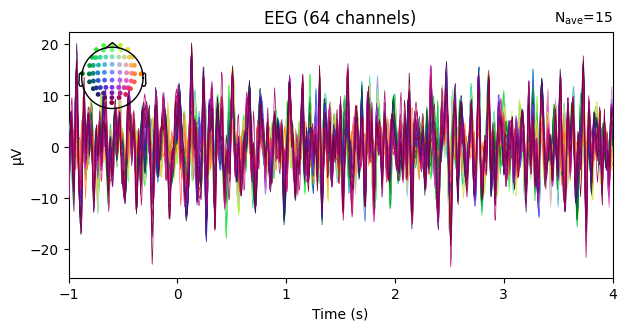

Just got epoch 17
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

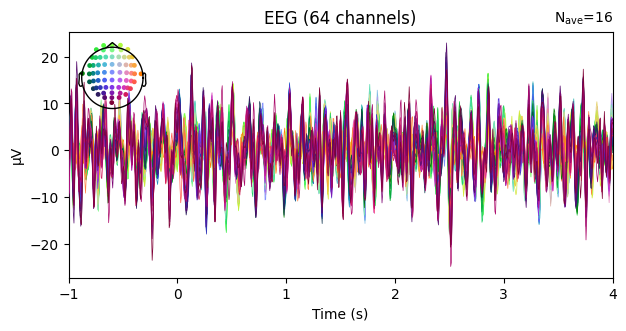

Waiting for epoch 18
Time of 2.0 seconds exceeded.


In [1]:
# Authors: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#          Mainak Jas <mainak@neuro.hut.fi>
#
# License: BSD (3-clause)

import matplotlib.pyplot as plt

import mne
from mne.io import Raw, RawArray
from mne.datasets import sample
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
from mne import  pick_types, events_from_annotations, set_log_level, pick_channels, create_info

from mne_realtime import RtEpochs, MockRtClient

import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

STIM_CHANNEL = 'STI 014'

set_log_level(verbose=False)


raw_fnames = eegbci.load_data(subject=1, runs=[6, 10, 14])                  # -Get paths to edf files.
# raw = read_raw_edf(raw_fnames[0], preload=True) # -Load(read_raw_edf) in memomry(preloard=True) recprdings and convcatenate them.
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames]) # -Load(read_raw_edf) in memomry(preloard=True) recprdings and convcatenate them.
eegbci.standardize(raw)  # set channel names                                # -Not sure what this does but it's necessary...
raw.set_montage(make_standard_montage("standard_1005"))                     # -Specify to MNE what montage/setup was used during the recording.
                                                                            #  "standard_1005" refers to a standardized way of placing electrodes on the testee.
                                                                            #  See https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG).

events, _ = events_from_annotations(raw, event_id=dict(T0=1, T1=2, T2=3))   # -Make events from annotaions, only use T1 and T2 annotations. Mark them as 0 and 1 respectively.
events = np.delete(events, 1, axis=1)
# print(events)
TYPE_I = 1
SAMPLE_I = 0                                                                #  According to the Physionet EEG-MI dataset web page(https://physionet.org/content/eegmmidb/1.0.0/),
                                                                            #  T0 corresponds to the motion of both fists and T1 to the motion of both feet.

# MAKE INFO 
stim_info = mne.create_info(ch_names=[STIM_CHANNEL], sfreq=raw.info['sfreq'], ch_types='stim')
# MAKE STIM_DATA FROM EVENTS
stim_data = np.empty((1, raw.get_data().shape[1]))
for i in range(events.shape[0] - 1):
    stim_data[0, events[i, 0]:events[i+1, 0]] = events[i, 1]
stim_data[0, events[-1, 0]:stim_data.shape[1]] = events[-1, 1]
# MAKE RAW FROM STIM_DATA AND INFO
raw_stim = RawArray(np.zeros((1, raw.get_data().shape[1])), stim_info)
# ADD CHANNELS 
raw.add_channels([raw_stim])
events_test, _ = events_from_annotations(raw, event_id=dict(T0=1, T1=2, T2=3))
raw.add_events(events_test, STIM_CHANNEL)

raw.filter(7.0, 30.0, skip_by_annotation="edge", verbose=False)                            # -Apply bandpass filter, only keep frequecies in the range 7-30 Hz.

# create the mock-real-time-client object
rt_client = MockRtClient(raw, verbose=True)
print(rt_client.get_event_data(1, 0, 2).shape)


picks = pick_types(raw.info, eeg=True, stim=True)                          # -Specify that we only want to listen to the EEG channels, the other channels are set to False by default.
plt.plot([1, 2, 3, 4])

set_log_level(verbose=True)
# create the real-time epochs object
rt_epochs = RtEpochs(
    rt_client,
    event_id=[0, 1],
    tmin=-1.0,
    tmax=4.0,
    picks=picks,
    decim=1
    )

# # start the acquisition
rt_epochs.start()
# # send raw buffers
rt_client.send_data(rt_epochs, picks, tmin=0, tmax=150, buffer_size=1000)
for ii, ev in enumerate(rt_epochs.iter_evoked()):
    print("Just got epoch %d" % (ii + 1))
    # ev.plot(picks)
    ev.pick_types(eeg=True, stim=True) 
    if ii == 0:
        evoked = ev
    else:
        evoked = mne.combine_evoked([evoked, ev], weights='nave')
    plt.clf()  # clear canvas
    evoked.plot()  # plot on current figure
    # plt.pause(0.05)